# VQ-VAE (Vector Quantized - Variational AutoEncoder)

This is an attempt to re-implement the paper AD-GAN

Paper: https://arxiv.org/pdf/1711.00937.pdf

Other Resources: 
* https://keras.io/examples/generative/vq_vae
* https://www.youtube.com/watch?v=VZFVUrYcig0

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = tf.cast(tf.expand_dims(x_train, -1), tf.float32)
x_test = tf.cast(tf.expand_dims(x_test, -1), tf.float32)
x_train_scaled = (x_train / 255.0)
x_test_scaled = (x_test / 255.0)

inp_shape = x_train_scaled.shape[1:]

In [3]:
class VectorQuantizer(tf.keras.layers.Layer):
    def __init__(self, num_embedding, embedding_dim, 
                 commitment_cost = 0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embedding = num_embedding
        self.commitment_cost = commitment_cost
        
        init = tf.random_uniform_initializer()
        self.codebook = tf.Variable(
            initial_value = init(
                shape = (self.num_embedding, self.embedding_dim), dtype = tf.float32
            ), trainable = True, name = 'embeddings_vqvae',
        )
        
    def call(self, z):
        z_shape = tf.shape(z)
        flat_z = tf.reshape(z, (-1, self.embedding_dim))
        
        # distance between z and codebook
        d = (
            tf.math.reduce_sum(flat_z ** 2, axis = 1, keepdims = True)  # sum over the axis of embed_dim
            + tf.math.reduce_sum(self.codebook ** 2, axis = 1)          # sum over the axis of embed_dim
            - 2 * tf.matmul(flat_z, self.codebook, transpose_b = True)
        )
        
        # Quantization
        embed_indices = tf.argmin(d, axis = 1)
        embeds = tf.one_hot(embed_indices, self.num_embedding)
        embeds = tf.matmul(embeds, self.codebook)
        quantized = tf.reshape(embeds, z_shape)
        
        # losses
        loss = tf.math.reduce_mean(
            (tf.stop_gradient(z) - quantized) ** 2
        ) + self.commitment_cost * tf.math.reduce_mean(
            (z - tf.stop_gradient(quantized)) ** 2
        )
        
        self.add_loss(loss)
        
        # straight-through estimator
        quantized = z + tf.stop_gradient(quantized - z)
        return quantized

In [4]:
def get_encoder_decoder(inp_size, dim, latent_dim, num_residual = 0, apply_out_sigmoid = True):
    
    def residual_block(x, d):
            r = tf.keras.layers.Conv2D(filters = d, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(x)
            r = tf.keras.layers.ReLU()(r)
            r = tf.keras.layers.Conv2D(filters = d, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(r)
            r = tf.keras.layers.ReLU()(r)
            return tf.keras.layers.Add()([r, x])
        
    # Encoder
    enc_inp = tf.keras.layers.Input(shape = inp_size, dtype = 'float32')
    enc = tf.keras.layers.Conv2D(filters = dim // 2, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(enc_inp)
    enc = tf.keras.layers.ReLU()(enc)
    enc = tf.keras.layers.Conv2D(filters = dim, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(enc)
    enc = tf.keras.layers.ReLU()(enc)
    for _ in range(num_residual):
        enc = residual_block(enc, dim)
    enc = tf.keras.layers.Conv2D(latent_dim, kernel_size = (1, 1), strides = (1, 1), padding = 'same')(enc)
    
    encoder = tf.keras.models.Model(enc_inp, enc, name = 'Encoder')
        
    # Decoder 
    dec_inp = tf.keras.layers.Input(shape = encoder.output_shape[1:], dtype = 'float32')
    dec = dec_inp
    for _ in range(num_residual):
        dec = residual_block(dec, latent_dim)
    dec = tf.keras.layers.Conv2DTranspose(filters = dim, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(dec)
    dec = tf.keras.layers.ReLU()(dec)
    dec = tf.keras.layers.Conv2DTranspose(filters = dim // 2, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(dec)
    dec = tf.keras.layers.ReLU()(dec)
    dec = tf.keras.layers.Conv2DTranspose(filters = inp_size[-1], kernel_size = (3, 3), strides = (1, 1), padding = 'same')(dec)

    if apply_out_sigmoid:
        dec = tf.keras.layers.Activation('sigmoid')(dec)
    decoder = tf.keras.models.Model(dec_inp, dec, name = 'Decoder')
    
    return encoder, decoder


In [5]:
class VQVAE(tf.keras.models.Model):
    def __init__(self, inp_size, num_embedding = 128, latent_dim = 256, dim = 64, num_residual = 0, 
                 apply_out_sigmoid = True, **kwargs):
        super().__init__(**kwargs)
        self.vqvae = self.__vqvae_model(inp_size, num_embedding, latent_dim, dim, num_residual, apply_out_sigmoid)
        
    def __vqvae_model(self, inp_size, num_embedding, latent_dim, dim = 64, num_residual = 0, apply_out_sigmoid = True):
        encoder, decoder = get_encoder_decoder(inp_size, dim, latent_dim)
        vqvae_inp = tf.keras.layers.Input(shape = inp_size, dtype = tf.float32)
        vq_vae = encoder(vqvae_inp)
        vq_vae = VectorQuantizer(num_embedding, latent_dim)(vq_vae)
        vq_vae = decoder(vq_vae)
        return tf.keras.models.Model(vqvae_inp, vq_vae, name = 'VQVAE')
    
    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        
    def summary(self):
        return self.vqvae.summary()
    
    def train_step(self, x):
        
        with tf.GradientTape() as tape:
            vqvae_out = self.vqvae(x)
            
            reconstruction_loss = tf.math.reduce_mean(tf.math.square(x - vqvae_out))
            total_loss = reconstruction_loss + tf.math.reduce_sum(self.vqvae.losses)
            
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))
        
        return {'total_loss': total_loss}

In [6]:
vqvae = VQVAE(inp_shape)
vqvae.compile(optimizer=tf.keras.optimizers.Adam())
losses = vqvae.fit(x_train_scaled, epochs = 30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 6s 9ms/step - total_loss: 0.2346A: 0s - tota
Epoch 2/30
469/469 [==============================] - 4s 9ms/step - total_loss: 0.0476
Epoch 3/30
469/469 [==============================] - 4s 8ms/step - total_loss: 0.0311A: 0s - total_loss: 
Epoch 4/30
469/469 [==============================] - 4s 9ms/step - total_loss: 0.0242
Epoch 5/30
469/469 [==============================] - 4s 9ms/step - total_loss: 0.0215
Epoch 6/30
469/469 [==============================] - 4s 9ms/step - total_loss: 0.0204A: 0s - total_loss:
Epoch 7/30
469/469 [==============================] - 4s 9ms/step - total_loss: 0.0199A: 1s - total_loss - ETA: 1s 
Epoch 8/30
469/469 [==============================] - 4s 9ms/step - total_loss: 0.0190
Epoch 9/30
469/469 [==============================] - 4s 9ms/step - total_loss: 0.0187A: 0s - total_los
Epoch 10/30
469/469 [==============================] - 4s 9ms/step - total_loss: 0.0182A: 1
Epoch 11/30
469/469 [=======

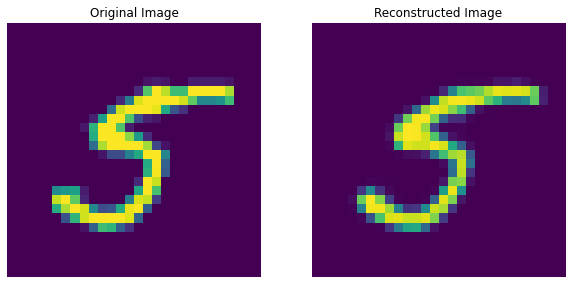

In [32]:
plt.figure(figsize = (10, 30))
num_examples = 1

for i in range(num_examples):
    idx = np.random.choice(np.arange(10000))
    orig_img = tf.expand_dims(x_test_scaled[idx], 0)
    recon_img = vqvae.vqvae(orig_img)

    plt.subplot(num_examples, 2, 2*i + 1)
    plt.title('Original Image')
    plt.imshow(orig_img[0])
    plt.axis('off')

    plt.subplot(num_examples, 2, 2*i + 2)
    plt.title('Reconstructed Image')
    plt.imshow(recon_img[0])
    plt.axis('off')

plt.show()